In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import Delaunay
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

import mygene

from pathlib import Path

import matplotlib.pyplot as plt
import pickle as pkl

In [2]:
path2root = Path('path to the directory of downloaded files')

In [3]:
sparse_LIBD_dataframe = pd.read_csv(path2root / 'LIBD_sparse_data.csv', header=0, index_col=0, names=['gene', 'spot', 'count'])

In [4]:
LIBD_gene_names = pd.read_csv(path2root / 'LIBD_gene_names.csv', header=0, index_col=0)

In [5]:
gene_names = LIBD_gene_names.values.flatten()
# to save time, we do not query the gene symbols in the default setting
if False:
    mg = mygene.MyGeneInfo()
    gene_symbols = mg.querymany(gene_names, scopes='ensembl.gene', fields="symbol", species="human", as_dataframe=True)
    gene_symbols = gene_symbols[~gene_symbols.index.duplicated(keep='first')]
    unmatched_mask = pd.isna(gene_symbols)["symbol"].values
    processed_gene_symbols = gene_symbols["symbol"].values.astype(str)
    processed_gene_symbols[unmatched_mask] = gene_symbols.index[unmatched_mask]
else:
    processed_gene_symbols = gene_names

In [6]:
def create_subset_matrix(dataframe, sample_id, coordinates, image_coordinates, labels, sample_name):
    subset_mask = (sample_id["x"] == sample_name)
    subset_index = sample_id[subset_mask].index
    subset = dataframe[dataframe["spot"].isin(subset_index)]

    subset_coordinates = coordinates[subset_mask.values]
    subset_image_coordinates = image_coordinates[subset_mask.values]
    subset_labels = labels[subset_mask.values]
    
    rows, columns = len(subset["spot"].unique()), dataframe["gene"].max()
    
    LIBD_data = csr_matrix((subset["count"], (subset["spot"] - subset["spot"].min(), subset["gene"] -1)), shape=(rows, columns)).toarray()
    
    return LIBD_data, subset_coordinates, subset_image_coordinates, subset_labels

In [7]:
LIBD_sample_ids = pd.read_csv(path2root / 'LIBD_sample_id.csv', header=0, index_col=0)
LIBD_spatial_coordinates = pd.read_csv(path2root / 'LIBD_coordinates.csv', header=0)
LIBD_image_coordinates = pd.read_csv(path2root / 'LIBD_image_coordinates.csv', index_col=0, header=0)
LIBD_labels = pd.read_csv(path2root / 'LIBD_annotations.csv', header=0)

sample_names = LIBD_sample_ids["x"].unique()
num_samples = len(sample_names)

data_directory = Path("../files")
data_directory.mkdir(parents=True, exist_ok=True)

In [8]:
def get_neighborhood(spot_locations):
    """Return adjacency matrix in sparse COO format (esssentially).
    """
    num_spots = len(spot_locations)
    adjacency_matrix = None
    np.random.seed(0)
    
    edges=[]
    threshold = 2 + 1e-3
    neighbor_model = NearestNeighbors(n_neighbors=6, radius=threshold).fit(spot_locations)
    real_neighbors = neighbor_model.radius_neighbors(spot_locations, return_distance=False)
    for vertex in range(num_spots):
        neighbors = real_neighbors[vertex]
        edges.extend([(vertex, neighbor) for neighbor in neighbors if vertex < neighbor])
            
    adjacency_matrix = np.array(edges)

    return adjacency_matrix

In [9]:
def write_spicemix_input(spot_data, raw_spot_data, gene_names, raw_gene_names, coordinates, image_coordinates, labels, sample_name, output_directory):
    """Write input files in correct format for SpiceMix.

    """
    
    output_directory.mkdir(parents=True, exist_ok=True)
    expression_filename = "expression_{}.pkl".format(sample_name)
    raw_expression_filename = "expression_{}_raw.pkl".format(sample_name)
    neighborhood_filename = "neighborhood_{}.txt".format(sample_name)
    coordinates_filename = "coordinates_{}.txt".format(sample_name)
    gene_names_filename = "genes_{}.txt".format(sample_name)
    raw_gene_names_filename = "genes_{}_raw.txt".format(sample_name)
    labels_filename = "labels_{}.txt".format(sample_name)
    meta_filename = "meta_{}.csv".format(sample_name)

    metadata = pd.DataFrame(np.transpose([coordinates[:, 0], coordinates[:, 1], image_coordinates[:, 0], image_coordinates[:, 1], labels]), columns=["coor X", "coor Y", "real X", "real Y", "cell type"])
    metadata.to_csv(Path(output_directory) / meta_filename, index=False)
    
    pd.DataFrame(coordinates).to_csv(Path(output_directory) / coordinates_filename, sep="\t", header=False, index=False)
    pd.DataFrame(labels).to_csv(Path(output_directory) / labels_filename, sep="\t", header=False, index=False)
    
    adjacency_matrix = get_neighborhood(coordinates)
    pd.DataFrame(adjacency_matrix).to_csv(Path(output_directory) / neighborhood_filename, sep="\t", header=False, index=False)

    total_spot_data = spot_data.sum(axis=1)
    transformed_gene_expression_data = np.log(1 + 10**4 * (spot_data / total_spot_data[:, np.newaxis]))

    with open(Path(output_directory) / expression_filename, "wb") as f:
        pkl.dump(transformed_gene_expression_data, f)
        
    with open(Path(output_directory) / raw_expression_filename, "wb") as f:
        pkl.dump(raw_spot_data, f)
    # pd.DataFrame(transformed_gene_expression_data).to_csv(Path(output_directory) / expression_filename, sep="\t", header=False, index=False)

    with open(Path(output_directory) / gene_names_filename, 'w') as filehandle:
        for gene in gene_names:
            filehandle.write('%s\n' % gene)
            
    with open(Path(output_directory) / raw_gene_names_filename, 'w') as filehandle:
        for gene in raw_gene_names:
            filehandle.write('%s\n' % gene)
            
    return adjacency_matrix

In [10]:
spot_data = []
spot_coordinates = []
spot_image_coordinates = []
spot_labels = []
for sample_name in sample_names:
    sample_spot_data, subset_coordinates, subset_image_coordinates, subset_labels = create_subset_matrix(sparse_LIBD_dataframe, LIBD_sample_ids, LIBD_spatial_coordinates, LIBD_image_coordinates, LIBD_labels, sample_name)
    spot_data.append(sample_spot_data)
    spot_coordinates.append(subset_coordinates)
    spot_image_coordinates.append(subset_image_coordinates)
    spot_labels.append(subset_labels)

In [11]:
# Filtering genes with less than 10% non-zeros across all samples
threshold = 0.1
nonzero_mask = np.full(sparse_LIBD_dataframe["gene"].max(), True)
for sample_spot_data in spot_data:
    sample_nonzero_mask = ((sample_spot_data != 0).sum(axis=0) / len(sample_spot_data) > threshold)
    nonzero_mask = (nonzero_mask & sample_nonzero_mask)


print("Number of HVGs: %d" % nonzero_mask.sum())
filtered_spot_data = [sample_spot_data[:, nonzero_mask] for sample_spot_data in spot_data]
filtered_genes = processed_gene_symbols[nonzero_mask]
filtered_raw_genes = gene_names[nonzero_mask]

Number of HVGs: 3194


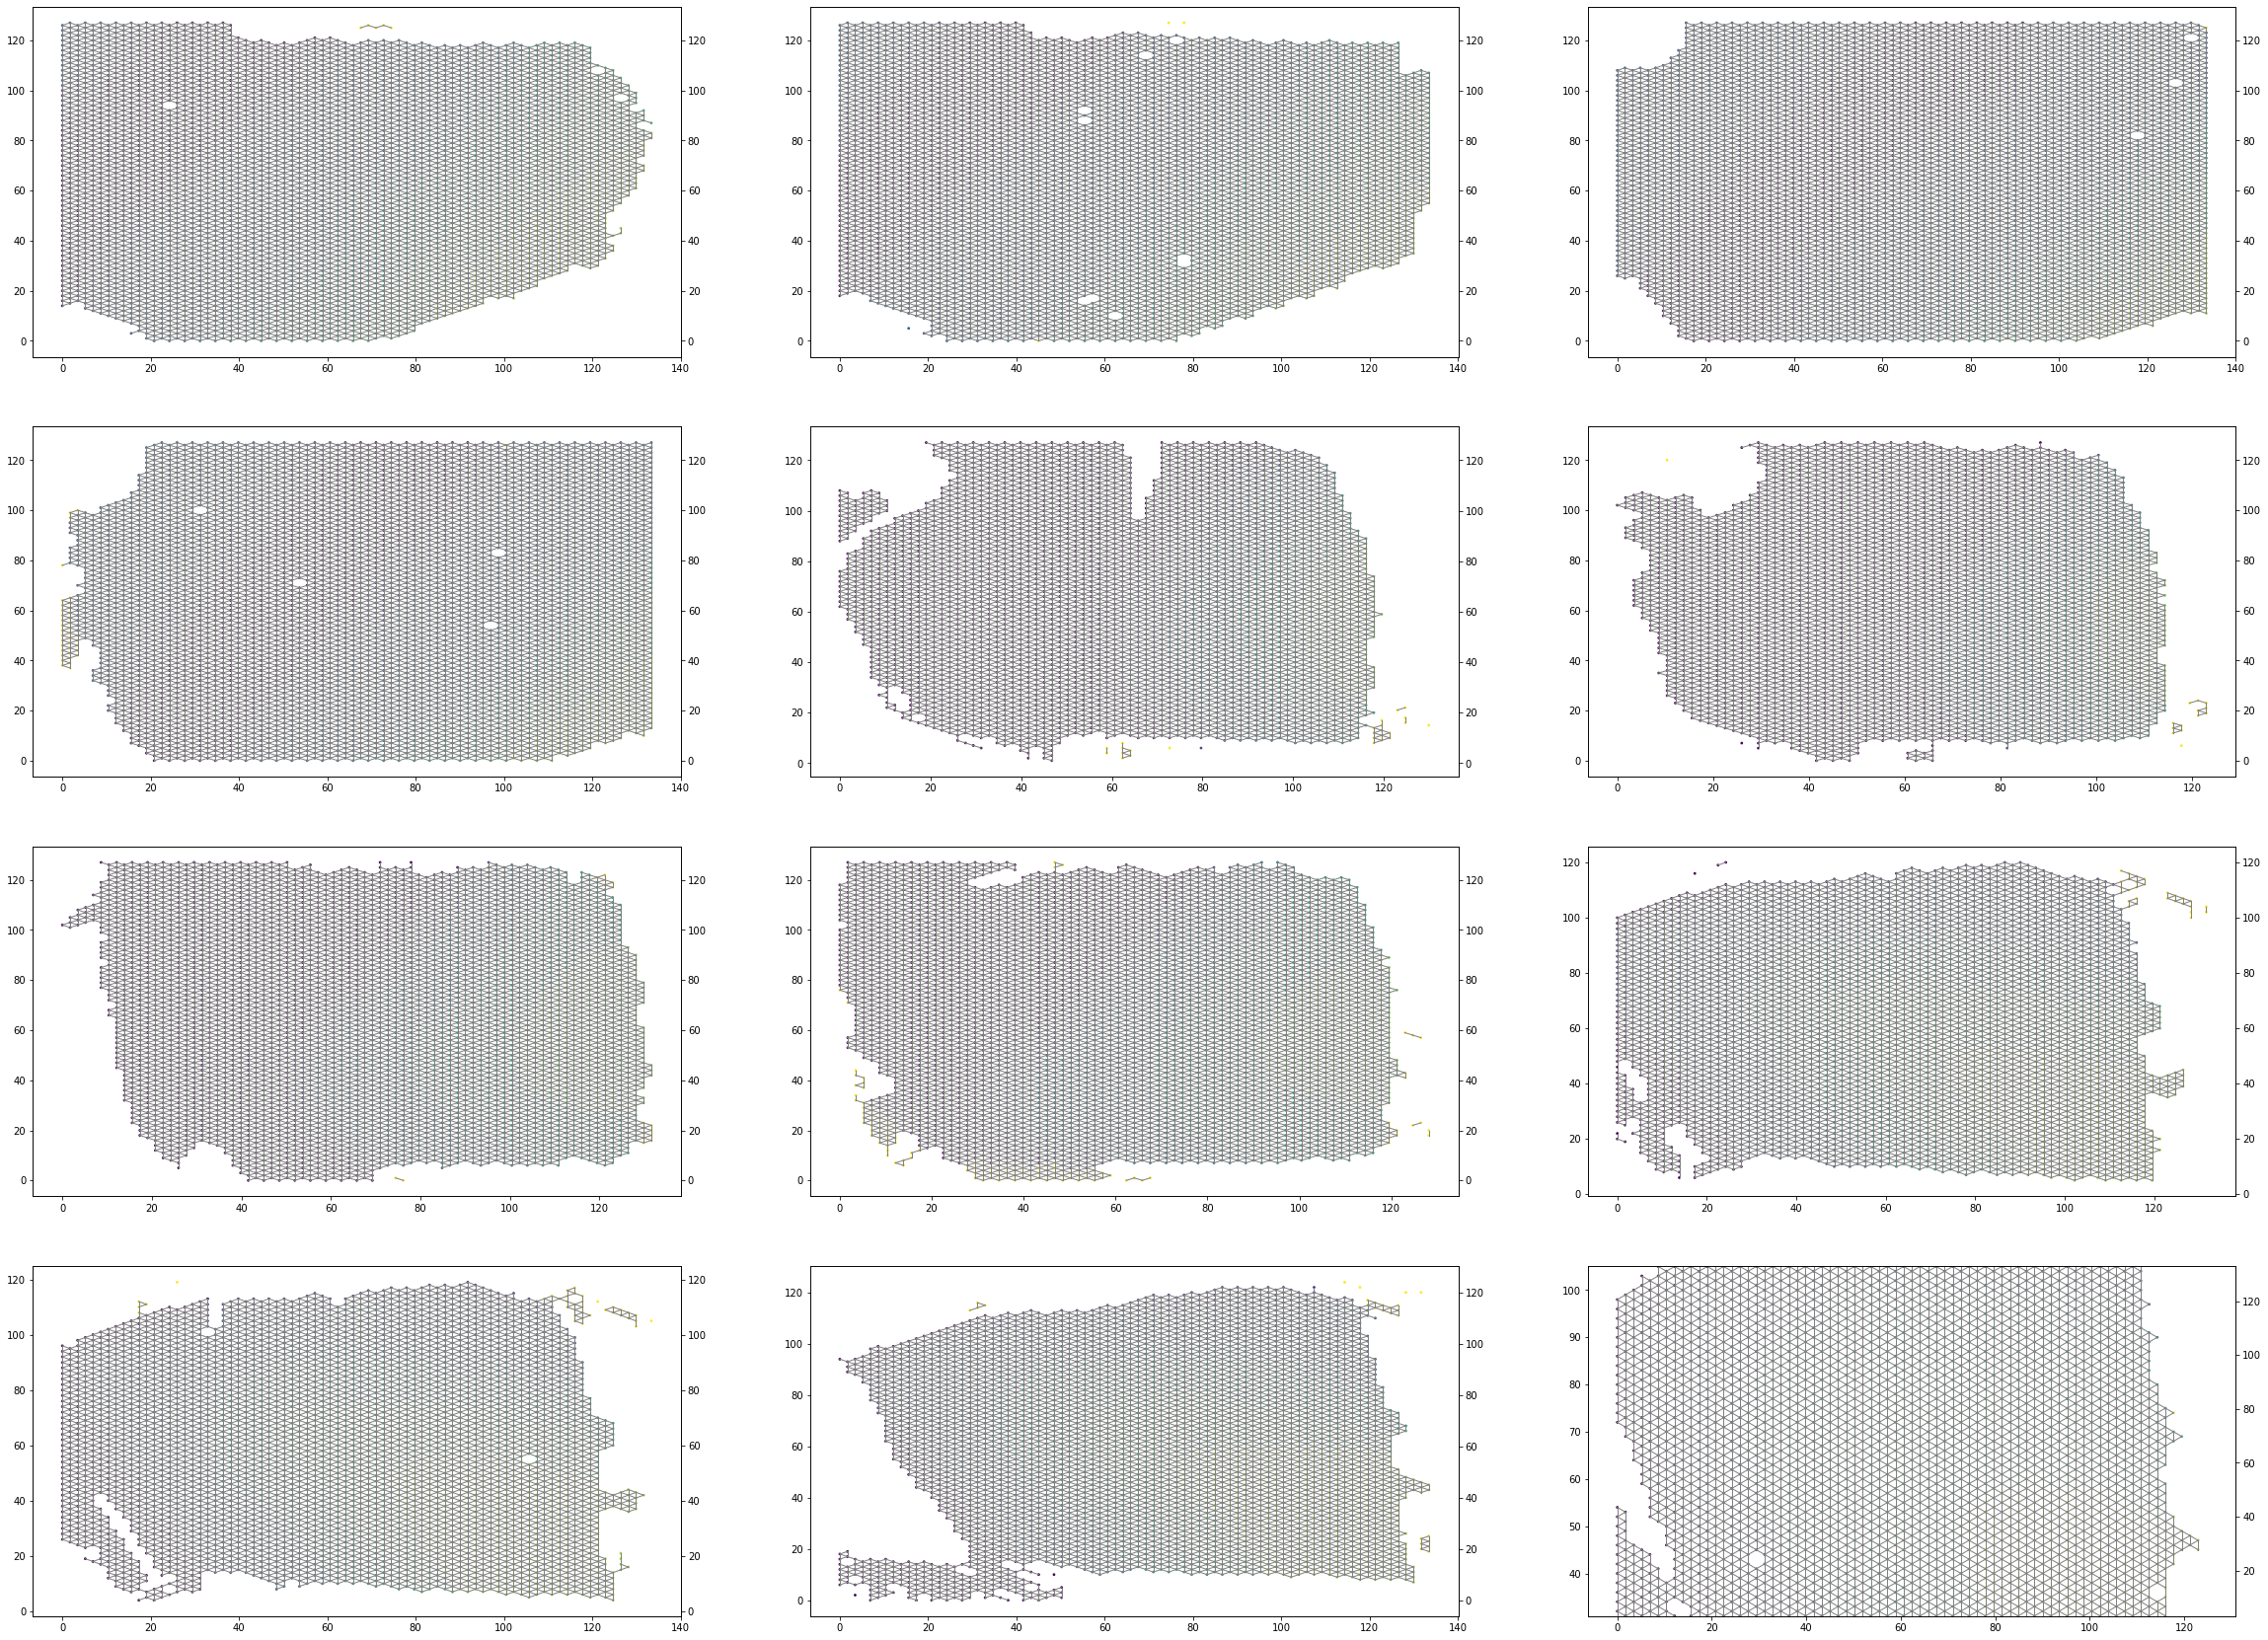

In [12]:
width = 3
height = num_samples // width + (num_samples % width != 0)
# width = 1
# height = 1
fig, axes= plt.subplots(height, width, figsize=(height * 10, width * 10), squeeze=False)
plt.gca().set_aspect('equal', adjustable='box')

for coordinates, image_coordinates, labels, sample_spot_data, raw_spot_data, sample_name, ax in zip(spot_coordinates, spot_image_coordinates, spot_labels, filtered_spot_data, spot_data, sample_names, axes.flat):
    spot_image_locations = image_coordinates[["x", "y"]].values
    spot_locations = coordinates[["array_row", "array_col"]].values.astype(np.float32)
    # Rescaling to lie on hexagonal grid
    spot_locations[:, 0] *= np.sqrt(3)
    labels = labels["x"].values.astype(str)

    adjacency_matrix = write_spicemix_input(sample_spot_data, raw_spot_data, filtered_genes, filtered_raw_genes, spot_locations, spot_image_locations, labels, sample_name, data_directory)
    
    for (source, destination) in adjacency_matrix:
        ax.plot([spot_locations[source, 0], spot_locations[destination, 0]],
            [spot_locations[source, 1], spot_locations[destination, 1]], color="gray", linestyle='solid', linewidth=1)

    top_ax = ax.twinx()
    top_ax.set_zorder(2)
    ax.set_zorder(1)
        
    _, integer_labels = np.unique(labels, return_inverse=True)
    x, y = spot_locations.T
    ax.scatter(x, y, s=3, c=integer_labels)
    ax.set_xlim(ax.get_xlim())
    top_ax.set_ylim(ax.get_ylim())